In [1]:
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

import argparse
import sys
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio
import sys
import argparse

C:\Users\giwef\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\giwef\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\giwef\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\giwef\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1, keepdims = None)
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores >= threshold
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [3]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max(xi2 - xi1, 0)
    inter_height = max(yi2 - yi1, 0)
    inter_area = inter_width * inter_height

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_y2 - box1_y1) * (box1_x2 - box1_x1)
    box2_area = (box2_y2 - box2_y1) * (box2_x2 - box2_x1)
    union_area = (box1_area + box2_area) - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')  # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))  # initialize variable max_boxes_tensor

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    # Given the boxes kept and it's scores, it will iterate to leave the one with the highest prob.
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes, iou_threshold=iou_threshold)

    # Use K.gather() to select only nms_indices from scores, boxes and classes
    # Using the index for the boxes left, get the scores, box, and classes for each.
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)

    return scores, boxes, classes

In [5]:
def yolo_eval(yolo_outputs, image_shape=(720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)

    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [6]:
def predict(sess, img, max_boxes = 10, score_threshold=.6, iou_threshold=.5):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    # Load image size
    input_image = imageio.imread(img)
    shape = (float(input_image.shape[0]), float(input_image.shape[1]))
    
    ## outputs
    scores, boxes, classes = yolo_eval(yolo_outputs, shape, max_boxes=max_boxes,
                                       score_threshold=score_threshold,iou_threshold=iou_threshold)

    # Preprocess your image
    image, image_data = preprocess_image(img, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run(fetches=[scores, boxes, classes],
                                                 feed_dict={yolo_model.input: image_data,
                                                           K.learning_phase(): 0})
    # Filter by desirerd classes
    indexes = []
    index = 0
    for cl in [class_names[i] for i in out_classes]:
        if cl in [class_names[i] for i in [0,1,2,3,5,7,9,11]]:
            indexes.append(index)
        index += 1
        
    out_scores = np.array([out_scores[i] for i in indexes])
    out_boxes = np.array([out_boxes[i] for i in indexes])
    out_classes = np.array([out_classes[i] for i in indexes])

    # Print predictions info
    # print('Found {} boxes for {}'.format(len(out_boxes), img))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save('output/predicted/'+ img[16:-4]+ '_predicted.png', quality=90)
    # Display the results in the notebook
    output_image = imageio.imread('output/predicted/'+ img[16:-4]+ '_predicted.png')
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [7]:
def video_to_image(pathIn, pathOut, fps):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*(1000/fps)))    # added this line 
        success,image = vidcap.read()
        if success:
            cv2.imwrite( pathOut + "\\frame%d.jpg" % count, image)     # save frame as JPEG file
        count = count + 1
        
def image_to_video(pathIn, pathOut, fps):
    images = [img for img in os.listdir(pathIn) if img.endswith(".jpg")]
    images = pd.Series(images).str.replace('frame', '').str.replace('.jpg', '').astype(int)
    images = ('frame' + pd.Series(np.sort(images)).astype(str) + '.jpg').tolist()
    frame = cv2.imread(os.path.join(pathIn, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(pathOut, 0,fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(pathIn, image)))

    cv2.destroyAllWindows()
    video.release()

In [8]:
def get_single_boxes(boxes):
    matching_boxes = []
    for b1 in boxes:
        matching_boxes1 = [b1]
        for b2 in boxes:
            if iou(b1, b2)>0.1 and b1 != b2:
                matching_boxes1.append(b2)
        matching_boxes1 = sorted(matching_boxes1, key=lambda x: x[0])
        matching_boxes.append(matching_boxes1)

    l = matching_boxes

    matching_boxes = []
    while len(l)>0:
        first, *rest = l
        first = set(first)

        lf = -1
        while len(first)>lf:
            lf = len(first)

            rest2 = []
            for r in rest:
                if len(first.intersection(set(r)))>0:
                    first |= set(r)
                else:
                    rest2.append(r)     
            rest = rest2

        matching_boxes.append(first)
        l = rest

    big_boxes = []
    for box in matching_boxes:
        x1 = min([cords[0] for cords in box])
        y1 = min([cords[1] for cords in box])
        x2 = max([cords[2] for cords in box])
        y2 = max([cords[3] for cords in box])

        big_box = (x1, y1, x2, y2)
        big_boxes.append(big_box)
    return big_boxes

## Beginning

In [27]:
def video_frames(video_file, fps = 15):
    video_to_image('input/' + video_file, 'input/frames', fps = fps)
    images = [img for img in os.listdir('input/frames') if img.endswith('.jpg')]
    print('Video turned to ' + str(len(images)) + ' frames')
    images = pd.Series(images).str.replace('frame', '').str.replace('.jpg', '').astype(int)
    images = ('frame' + pd.Series(np.sort(images)).astype(str) + '.jpg').tolist()
    # empty list to store the frames
    col_images=[]

    for i in images:
        # read the frames
        img = cv2.imread('input/frames/'+i)
        # append the frames to the list
        col_images.append(img)
    return col_images

In [28]:
frames_input = video_frames('video_input.avi')

Video turned to 116 frames


C:\Users\giwef\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


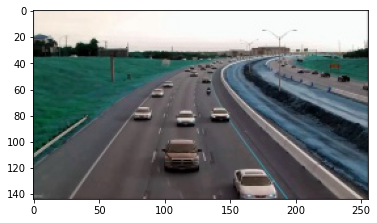

In [29]:
plt.imshow(frames_input[18])

In [85]:
def line_config(img, upperx, lowerx, uppery, lowery):
    shape_img = img.shape
    # directory to save the ouput frames
    if uppery == -1:
        uppery = shape_img[0]
        
    if upperx == -1:
        upperx = shape_img[1]
        
    if lowerx == -1:
        lowerx = 0
        
    if lowery == -1:
        lowery = 0
    
    if lowery > 0:
        cv2.line(img, (0, lowery),(shape_img[1],lowery),(100, 255, 255))
        print('y >= ' + str(lowery))
        
    if lowerx > 0:
        cv2.line(img, (lowerx, 0),(lowerx,shape_img[0]),(100, 255, 255))
        print('x >= ' + str(lowerx))
    if upperx < shape_img[1]:
        cv2.line(img, (upperx, 0),(upperx,shape_img[0]),(100, 255, 255))
        print('x < ' + str(upperx))
    if uppery < shape_img[0]:
        cv2.line(img, (0, uppery),(shape_img[1],uppery),(100, 255, 255))
        print('y < ' + str(uppery))
    plt.imshow(img)

x >= 40
x < 200
y < 80


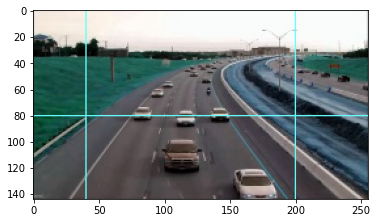

In [86]:
line_config(frames_input[18], 200, 40,80,-1)

In [60]:
def catch_moving_cars(images, pathIn = "output/frames/",pathIn2 = "output/vehicles/",upperx = 200,lowerx = -1,
                      uppery = -1,lowery = 80):
    
        
    
    # kernel for image dilation
    kernel = np.ones((4,4),np.uint8)

    # font style
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # shape image 
    shape_img = col_images[0].shape
    
    # directory to save the ouput frames
    if uppery == -1:
        uppery = shape_img[0]
        
    if upperx == -1:
        upperx = shape_img[1]
        
    if lowerx == -1:
        lowerx = 0
        
    if lowery == -1:
        lowery = 0
    
    no_cars_prev = 0
    j = 0
    for i in range(len(col_images)-1):

        # frame differencing
        grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
        diff_image = cv2.absdiff(grayB, grayA)

        # image thresholding
        ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

        # image dilation
        dilated = cv2.dilate(thresh,kernel,iterations = 1)

        # find contours
        _, contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

        # shortlist contours appearing in the detection zone
        valid_cntrs = []
        boxes = []
        for cntr in contours:
            x,y,w,h = cv2.boundingRect(cntr)
            if (x <= upperx) & (x >= lowerx) & (y >= lowery) & (y <= uppery) & (cv2.contourArea(cntr) >= 25):
                valid_cntrs.append(cntr)
                # transform contours to boxes
                rect = cv2.boundingRect(cntr)
                x,y,w,h = rect
                boxes.append((x-5,y-5,x+w+5,y+h+5))

        # combine boxes   
        boxes2 = get_single_boxes(boxes)
        boxes2 = sorted(boxes2, key=lambda x: x[1])
        boxes4 = []
        # condition to add car to list to classify
        if len(boxes2)>no_cars_prev:
            new_cars = len(boxes2)-no_cars_prev

            boxes3 = boxes2[:new_cars]
            boxes4 = [b for b in boxes3 if b[1]<=lowery*1.1]

        elif len(boxes2) == no_cars_prev & sum([b[1] for b in boxes2_t]) < sum([b[1] for b in boxes2]):
            new_cars = 1
            boxes3 = boxes2[:1]
            boxes4 = [b for b in boxes3 if b[1]<=lowery*1.1]
        else:
            new_cars = 0

        # add contours to original frames
        dmy = col_images[i].copy()
        for b in boxes2:
            x1,y1,x2,y2 = b
            cv2.rectangle(dmy,(x1,y1),(x2,y2),(0,255,0),2)
        boxes2_t = boxes2 # save boxes of t-1
        
        
        cv2.putText(dmy, "vehicles detected: " + str(new_cars), (55, 15), font, 0.6, (0, 180, 0), 2)
        if lowery > 0:
            cv2.line(dmy, (0, lowery),(shape_img[1],lowery),(100, 255, 255))
        
        if lowerx > 0:
            cv2.line(dmy, (lowerx, 0),(lowerx,shape_img[0]),(100, 255, 255))
        
        if upperx < shape_img[1]:
            cv2.line(dmy, (upperx, 0),(upperx,shape_img[0]),(100, 255, 255))
        
        if uppery < shape_img[0]:
            cv2.line(dmy, (0, uppery),(shape_img[1],uppery),(100, 255, 255))
        
        cv2.imwrite(pathIn+str(i)+'.png',dmy)  

        # save cars to classify
        dmy = col_images[i].copy()
        for b in boxes4:
            (x1, y1, x2, y2) = b
            cv2.imwrite(pathIn2+str(j)+'.png',dmy[y1:y2, x1:x2])
            j += 1

        no_cars_prev = len(boxes2)
print('captured valid vehicles')

In [61]:
catch_moving_cars(frames_input, pathIn = "output/frames/",pathIn2 = "output/vehicles/",upperx = 200,lowerx = -1,
                      uppery = -1,lowery = 80)

In [62]:
sess = K.get_session()
class_names = read_classes("model/coco_classes.txt")
anchors = read_anchors("model/yolo_anchors.txt")
yolo_model = load_model("model/yolo.h5")
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
yolo_outputs = (yolo_outputs[2],yolo_outputs[0], yolo_outputs[1], yolo_outputs[3])

C:\Users\giwef\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [80]:
images = [img for img in os.listdir("output/vehicles/") if img.endswith(".png")]
images = pd.Series(images).str.replace('.png', '').astype(int)
images = (pd.Series(np.sort(images)).astype(str) + '.png').tolist()

core_threshold=.1
counter = []
for img in images:
    _, _, out_classes = predict(sess, 'output/vehicles/'+img, 1,core_threshold,0.01)
    counter.append(out_classes)
    
print('Predicted type of captured vehicles')

In [81]:
final_counter = {
    'car':0,
    'motorbike':0,
    'truck':0,
    'bus':0
}
for c in counter:
    if len(c)==1:
        res = class_names[c[0]]
        if res == 'person': # yolo.v2 classifies motorcycles as person some times
            res = 'motorbike'
        final_counter[res]+=1

In [82]:
final_counter

{'car': 9, 'motorbike': 1, 'truck': 2, 'bus': 0}